# Import

In [10]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from tqdm import tqdm
from os import path

%matplotlib inline

np.random.seed(seed=42)

DATA_ROOT = 'data'

# Anime reviews analysis



Let's take a dataset with anime ratings: https://www.kaggle.com/CooperUnion/anime-recommendations-database  

```
Anime.csv

anime_id - myanimelist.net's unique id identifying an anime.
name - full name of anime.
genre - comma separated list of genres for this anime.
type - movie, TV, OVA, etc.
episodes - how many episodes in this show. (1 if movie).
rating - average rating out of 10 for this anime.
members - number of community members that are in this anime's "group".


Rating.csv

user_id - non identifiable randomly generated user id.
anime_id - the anime that this user has rated.
rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).
```

In [11]:
anime = pd.read_csv(path.join(DATA_ROOT, 'anime.csv.zip'), index_col='anime_id')
anime.dropna(inplace=True)
print(anime.shape)
anime.head()

(12017, 6)


,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [12]:
ratings = pd.read_csv(path.join(DATA_ROOT, 'rating.csv.zip'))
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


## Drop rows with -1 rating value

In [13]:
ratings = ratings[ratings['rating'] >= 0]
ratings.shape

(6337241, 3)

## Chavenet criterion

$$ erfc(\frac{|P_i - mean(P)|}{S_p})  < \frac{1}{2n}$$

$ S_p - deviation $

In [14]:
from scipy.special import erfc

def chauvenet(array):
    n = array.shape[0]
    m = array.mean()
    s_p = array.std()
    mask = erfc(abs(array - m)/s_p) < 0.5 / n
    return mask

### Cleaning ratings

In [15]:
count_reviews = ratings.groupby('user_id').size()
count_reviews

user_id
1          4
2          1
3         92
5        459
7        343
        ... 
73512     12
73513     33
73514      1
73515    179
73516      2
Length: 69600, dtype: int64

In [16]:
outlier_users = count_reviews[chauvenet(count_reviews.values)]
outlier_users

user_id
226      742
271      599
294      675
392      598
446      743
        ... 
73356    565
73362    596
73378    723
73395    585
73499    603
Length: 1216, dtype: int64

In [17]:
bad_user_threshold = outlier_users.min()
bad_user_threshold

np.int64(522)

In [18]:
count_reviews_df = pd.DataFrame({'user_id': count_reviews.index, 'count_reviews': count_reviews.values})
ratings = pd.merge(ratings, count_reviews_df, on='user_id', how='inner')
ratings = ratings[ratings['count_reviews'] < bad_user_threshold]
ratings

,user_id,anime_id,rating,count_reviews
0,1,8074,10,4
1,1,11617,10,4
2,1,11757,10,4
3,1,15451,10,4
4,2,11771,10,1
...,...,...,...,...
6337236,73515,16512,7,179
6337237,73515,17187,9,179
6337238,73515,22145,10,179
6337239,73516,790,9,2


In [19]:
median_cnt = ratings['count_reviews'].median()
ratings = ratings[ratings['count_reviews'] >=  median_cnt]
ratings = ratings.drop(columns=['count_reviews'])
ratings.shape

(2708042, 3)

### Cleaning anime

In [20]:
anime.describe()

,rating,members
count,12017.000000,1.201700e+04
mean,6.478264,1.834888e+04
std,1.023857,5.537250e+04
min,1.670000,1.200000e+01
25%,5.890000,2.250000e+02
50%,6.570000,1.552000e+03
75%,7.180000,9.588000e+03
max,10.000000,1.013917e+06


In [21]:
outlier_anime = anime[chauvenet(anime['members'])]
anime.drop(outlier_anime.index, inplace=True)
outlier_anime = anime[chauvenet(anime['rating'])]
anime.drop(outlier_anime.index, inplace=True)
anime.shape

(11655, 6)

In [22]:
anime.describe()

,rating,members
count,11655.000000,11655.000000
mean,6.468678,11819.027799
std,0.961762,26137.318826
min,3.540000,17.000000
25%,5.890000,223.000000
50%,6.550000,1479.000000
75%,7.150000,8351.000000
max,9.330000,178553.000000


## Aggregation data

In [23]:
from itertools import chain

def flatmap(f, items):
    return chain.from_iterable(map(f, items))

list(flatmap(lambda x: [0, x , x*x], [1,2,3,4,5]))
# first step: [[0, 1, 1], [0, 2, 4], [0, 3, 9], [0, 4, 16], [0, 5, 25]]

[0, 1, 1, 0, 2, 4, 0, 3, 9, 0, 4, 16, 0, 5, 25]

In [24]:
# create a function that simply splits a string by the ", " character into substrings
def genre_splitter(genre_names):
    return genre_names.split(", ")

# let's see how many unique combinations of genres there are in the dataset
m_uniq = anime['genre'].unique() 

# break all genres into their component parts and generate one array of all genres. Build a set of unique genres from the array
genres = set(flatmap(genre_splitter, m_uniq))
genres = list(genres) # set to list
print("Genres={}\nlen={}".format(genres, len(genres)))

Genres=['School', 'Military', 'Shounen Ai', 'Supernatural', 'Yaoi', 'Shoujo Ai', 'Mystery', 'Psychological', 'Space', 'Samurai', 'Magic', 'Thriller', 'Comedy', 'Ecchi', 'Parody', 'Josei', 'Adventure', 'Slice of Life', 'Demons', 'Sci-Fi', 'Martial Arts', 'Yuri', 'Historical', 'Cars', 'Music', 'Police', 'Romance', 'Vampire', 'Game', 'Drama', 'Dementia', 'Fantasy', 'Shounen', 'Mecha', 'Hentai', 'Shoujo', 'Horror', 'Action', 'Kids', 'Super Power', 'Sports', 'Seinen', 'Harem']
len=43


### Creating a one-hot encoding table

In [25]:
anime

,name,genre,type,episodes,rating,members
anime_id,,,,,,
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679
15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534
...,...,...,...,...,...,...
9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
5543,Under World,Hentai,OVA,1,4.28,183
5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219


In [26]:
anime['genres'] = anime['genre'].apply(lambda g: g.split(', '))

one_hot_df = anime.explode('genres')
one_hot_encoded = pd.get_dummies(one_hot_df['genres'])
anime_genre = one_hot_encoded.groupby('anime_id').sum()

We need to get another table, in which the rows will contain users, and the columns will contain anime genres. And in the cells, the average genre rating by this user.

The average genre rating is calculated as follows: we take all the user's reviews. We group all his reviews by genre and calculate the average rating that he gives to anime with this genre.

### Merge tables

In [27]:
anime_genre

,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
anime_id,,,,,,,,,,,,,,,,,,,,,
5,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
7,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
15,1,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
16,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34453,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34464,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34475,1,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [28]:
df = pd.merge(ratings, anime_genre, on='anime_id', how='inner')
df

,user_id,anime_id,rating,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,5,15,6,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,5,17,6,0,0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,0
2,5,18,6,1,0,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
3,5,22,5,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,5,24,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1817519,73515,13331,9,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1817520,73515,13599,7,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1817521,73515,16512,7,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1817522,73515,17187,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
def get_mean_genre(x):
    s = x.values.sum()
    if s: return (x * df.loc[x.index, 'rating']).sum() / s
    else: return None
df_grouped = df.groupby('user_id')[genres].agg(get_mean_genre)

In [31]:
df_grouped.head()

,School,Military,Shounen Ai,Supernatural,Yaoi,Shoujo Ai,Mystery,Psychological,Space,Samurai,...,Mecha,Hentai,Shoujo,Horror,Action,Kids,Super Power,Sports,Seinen,Harem
user_id,,,,,,,,,,,,,,,,,,,,,
5,3.505155,4.000,NaN,4.254237,NaN,1.000,3.933333,3.600000,7.250000,6.888889,...,2.000000,NaN,2.666667,4.25,4.717172,5.437500,4.400000,5.888889,4.441860,2.058824
7,6.915663,6.200,NaN,7.313725,NaN,8.000,7.823529,8.000000,NaN,6.000000,...,7.714286,NaN,7.500000,7.80,7.227273,8.333333,7.714286,7.333333,7.162791,7.083333
17,6.540984,7.125,NaN,6.930233,NaN,6.125,6.692308,7.090909,7.444444,8.000000,...,6.588235,NaN,5.250000,5.80,6.625000,6.500000,6.000000,6.923077,6.638889,6.416667
21,7.277778,NaN,6.0,7.190476,NaN,6.000,7.375000,8.307692,8.200000,7.000000,...,7.142857,NaN,6.800000,7.50,6.740741,6.000000,7.500000,7.000000,7.333333,6.400000
38,5.157895,5.400,3.0,6.465116,NaN,4.000,7.666667,8.333333,6.750000,6.500000,...,6.000000,NaN,2.000000,5.70,6.166667,NaN,5.950000,8.000000,6.250000,4.117647


In [32]:
df_grouped.fillna(-1, inplace=True)
df_grouped.head()

,School,Military,Shounen Ai,Supernatural,Yaoi,Shoujo Ai,Mystery,Psychological,Space,Samurai,...,Mecha,Hentai,Shoujo,Horror,Action,Kids,Super Power,Sports,Seinen,Harem
user_id,,,,,,,,,,,,,,,,,,,,,
5,3.505155,4.000,-1.0,4.254237,-1.0,1.000,3.933333,3.600000,7.250000,6.888889,...,2.000000,-1.0,2.666667,4.25,4.717172,5.437500,4.400000,5.888889,4.441860,2.058824
7,6.915663,6.200,-1.0,7.313725,-1.0,8.000,7.823529,8.000000,-1.000000,6.000000,...,7.714286,-1.0,7.500000,7.80,7.227273,8.333333,7.714286,7.333333,7.162791,7.083333
17,6.540984,7.125,-1.0,6.930233,-1.0,6.125,6.692308,7.090909,7.444444,8.000000,...,6.588235,-1.0,5.250000,5.80,6.625000,6.500000,6.000000,6.923077,6.638889,6.416667
21,7.277778,-1.000,6.0,7.190476,-1.0,6.000,7.375000,8.307692,8.200000,7.000000,...,7.142857,-1.0,6.800000,7.50,6.740741,6.000000,7.500000,7.000000,7.333333,6.400000
38,5.157895,5.400,3.0,6.465116,-1.0,4.000,7.666667,8.333333,6.750000,6.500000,...,6.000000,-1.0,2.000000,5.70,6.166667,-1.000000,5.950000,8.000000,6.250000,4.117647


# Clustering by genres

## Fit KMeans

### Scaling features

```
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min
```

In [33]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_gr_scaled = scaler.fit_transform(df_grouped)

### Fit kMeans with 10 clusters

In [34]:
clustering = KMeans(n_clusters=10, random_state=42)
kmeans = clustering.fit(df_gr_scaled)

### Plotting cluster centers using heatmap

<Axes: >

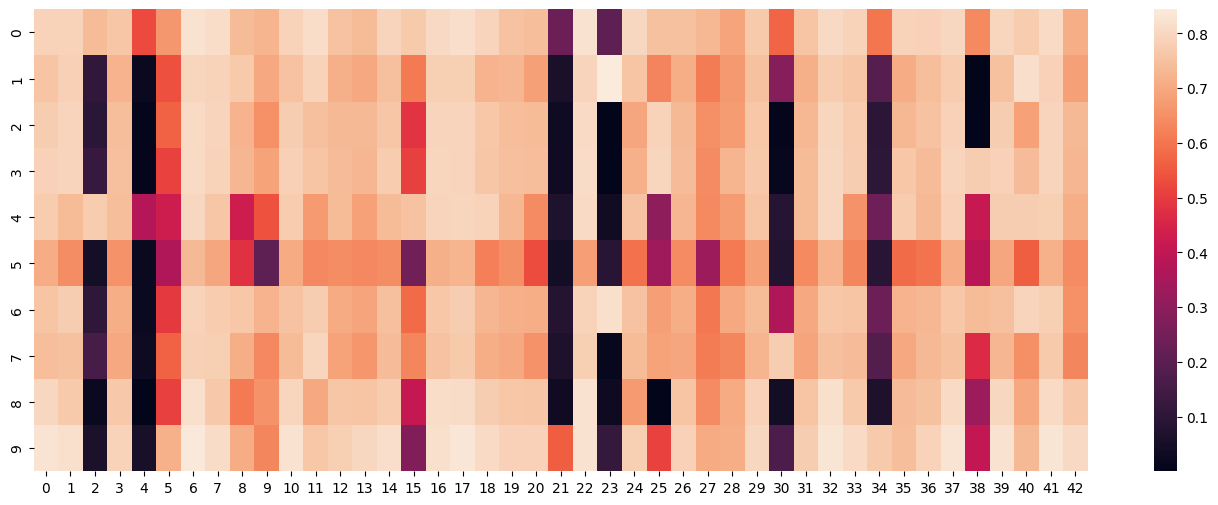

In [35]:
plt.figure(figsize=(17, 6))
sns.heatmap(kmeans.cluster_centers_)

## Selecting the optimal number of clusters

### Inertia coefficient

100%|██████████| 18/18 [00:03<00:00,  5.36it/s]


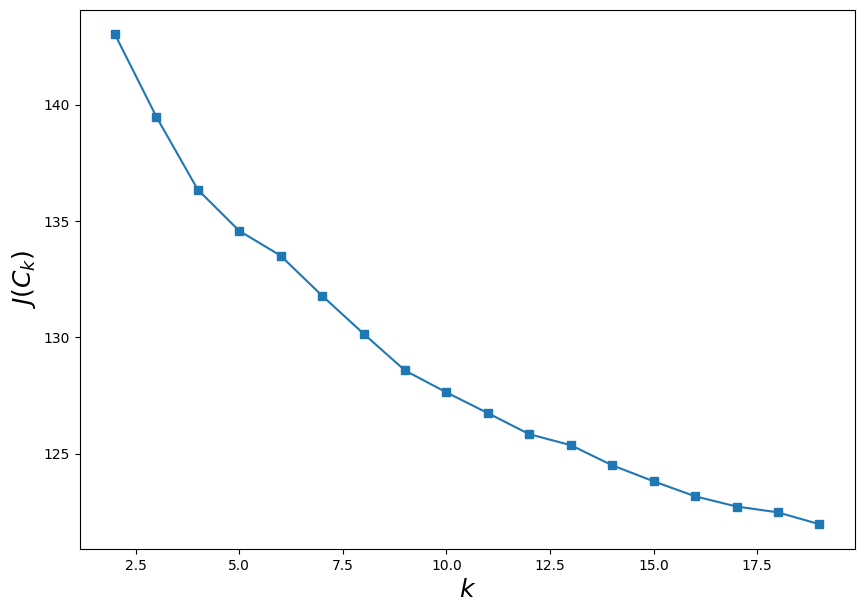

In [58]:
inertia = []
N = 20
for k in tqdm(range(2, N)):
    kmeans = KMeans(n_clusters=k).fit(scaler.fit_transform(df_grouped))
    inertia.append(np.sqrt(kmeans.inertia_))
plt.figure(figsize=(10,7))
plt.plot(range(2, N), inertia, marker='s')
plt.xlabel('$k$', fontsize=18)
plt.ylabel('$J(C_k)$', fontsize=18)
plt.show()

### Silhouette coefficient

In [59]:
from sklearn.metrics import silhouette_score

def draw_sil_score(X, range_n_clusters=[2, 3, 4, 5, 6, 10, 12, 13, 20]):
    scores = []
    for n_clusters in tqdm(range_n_clusters):
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        scores.append(silhouette_avg)
    plt.plot(range_n_clusters, scores)
    plt.xticks(range_n_clusters)
    plt.xlabel('$k$', fontsize=18)
    plt.ylabel('Silhouette value', fontsize=18)
    return range_n_clusters[np.argmax(scores)]

100%|██████████| 18/18 [00:23<00:00,  1.30s/it]


2

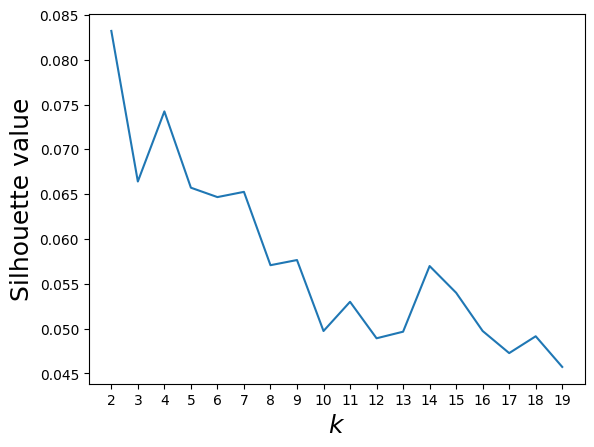

In [60]:
draw_sil_score(scaler.fit_transform(df_grouped), range(2, 20))

### Fit KMeans with `n_clusters=4`

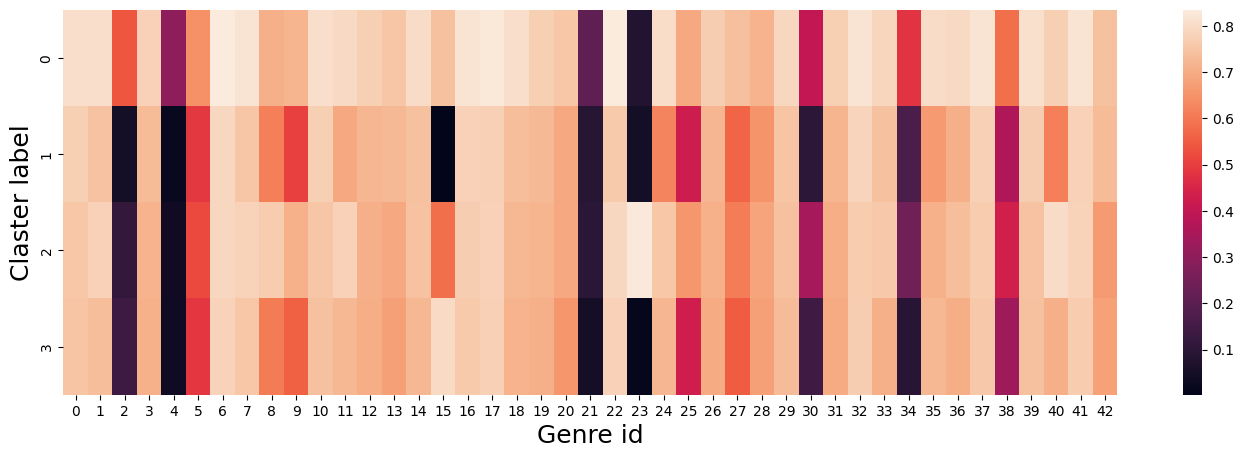

In [48]:
K = 4
clustering_top = KMeans(n_clusters=K, random_state=42)
kmeans = clustering_top.fit(df_gr_scaled)

plt.figure(figsize=(17, 5))
sns.heatmap(kmeans.cluster_centers_)
plt.xlabel('Genre id', fontsize=18)
plt.ylabel('Claster label', fontsize=18)
plt.show()

# Recommendation system algorithm

## Get user cluster by their reviews

In [182]:
total_view = 30
views_history = np.random.choice(anime.index, total_view)
anime.loc[views_history].head()

,name,genre,type,episodes,rating,members,genres
anime_id,,,,,,,
3853,Crayon Shin-chan Manatsu no Yoru ni Ora Sanjou...,"Action, Comedy, Kids, Shounen, Super Power",Special,1,6.82,1213,"[Action, Comedy, Kids, Shounen, Super Power]"
28069,Shigatsu wa Kimi no Uso: Moments,"Music, Shounen",OVA,1,7.81,41368,"[Music, Shounen]"
1124,Seikai no Danshou: Tanjou,"Military, Romance, Sci-Fi, Space",Special,1,7.32,5324,"[Military, Romance, Sci-Fi, Space]"
7803,Challenge Ichinensei de Kakkoii Ichinensei ni ...,Kids,OVA,1,5.86,176,[Kids]
13959,Milky Gal: Cats Ai,Hentai,OVA,1,4.08,164,[Hentai]


In [183]:
# random user genre rating statistics
user = np.random.uniform(low=0, high=1, size=(1, len(genres)))

label = clustering_top.predict(user)[0]
cluster = clustering_top.cluster_centers_[label]
print('cluster:', label)

cluster: 3


## Processing claster label

In [184]:
# find anime of popular genres in this cluster
def get_best_anime(cluster, top_k=10, combo=4):
    top_genres_ind = np.argsort(cluster)[-top_k:]
    top_genres = np.array(genres)[top_genres_ind]
    combo_anime = np.array([0] * df.shape[0])
    for g in top_genres:
        combo_anime += df[g]
    result_anime = df[combo_anime >= combo]
    if result_anime.shape[0]:
        return result_anime['anime_id'].unique()
    return get_best_anime(cluster, top_k + 1, combo - 1)

anime_id = get_best_anime(cluster, top_k=len(genres) // 8, combo=4)
anime_id

array([23317, 21329, 21939, 24687, 24701,  3901, 10504,  2246, 28957,
        9938,  1013,   345,  2035, 10804, 10832, 10905,  2517,  5157])

## Remove watched anime from recommendations

In [185]:
mask = ~np.isin(anime_id, views_history)
anime_id = anime_id[mask]
anime_id

array([23317, 21329, 21939, 24687, 24701,  3901, 10504,  2246, 28957,
        9938,  1013,   345,  2035, 10804, 10832, 10905,  2517,  5157])

## Take top 5 by rating

In [186]:
top_num = 5 if anime_id.shape[0] > 5 else anime_id.shape[0]
anime_id

array([23317, 21329, 21939, 24687, 24701,  3901, 10504,  2246, 28957,
        9938,  1013,   345,  2035, 10804, 10832, 10905,  2517,  5157])

In [187]:
# select top anime and display their names and ratings
anime_rating = anime.loc[anime_id].sort_values(by='rating', ascending=False)[:top_num]
recomedation = anime_rating[['name', 'rating']]
recomedation

,name,rating
anime_id,,
24701,Mushishi Zoku Shou 2nd Season,8.88
21939,Mushishi Zoku Shou,8.80
28957,Mushishi Zoku Shou: Suzu no Shizuku,8.75
21329,Mushishi Special: Hihamukage,8.66
24687,Mushishi Zoku Shou: Odoro no Michi,8.54
